In [1]:
# Install czmodel and dependencies (only needed once)
#! pip install --upgrade pip
#! pip install czmodel
#!pip install sklearn tifffile tqdm opencv-python

In [1]:
# imports to train a simple TF2 + Keras model for segmentation

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
sys.path.append('lib')
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from lib.data import load_training_data, load_training_paths, tf_dataset
from lib.model import build_model
from lib.data import load_prediction_data, load_prediction_paths

import tifffile
from tqdm import tqdm

# Optional: suppress TF warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print(tf.version.GIT_VERSION, tf.__version__)
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

v2.2.0-rc4-8-g2b96f3662b 2.2.0
# GPUs Available:  1


In [3]:
EPOCHS = 10
BATCH_SIZE = 1
PATIENCE = 50

In [4]:
### LOAD TRAINING AND TEST DATA ###
#input_path, output_path = load_training_paths()
#input_path = r"C:/Users/m1srh/Documents/GitHub/ipy_notebooks/Create_czmodel/mouse_embryo/images"
#output_path = r"C:/Users/m1srh/Documents/GitHub/ipy_notebooks/Create_czmodel/mouse_embryo/label"
input_path = r"C:/Users/m1srh/Documents/GitHub/ipy_notebooks/Create_czmodel/nucleus_data/images"
output_path = r"C:/Users/m1srh/Documents/GitHub/ipy_notebooks/Create_czmodel/nucleus_data/label"
model_path = Path(input_path).parent

print('Input Path  : ', input_path)
print('Output Path : ', output_path)
print('Model Path  : ', model_path)

Input Path  :  C:/Users/m1srh/Documents/GitHub/ipy_notebooks/Create_czmodel/nucleus_data/images
Output Path :  C:/Users/m1srh/Documents/GitHub/ipy_notebooks/Create_czmodel/nucleus_data/label
Model Path  :  C:\Users\m1srh\Documents\GitHub\ipy_notebooks\Create_czmodel\nucleus_data


In [5]:
(train_input, valid_input), (train_output, valid_output) = load_training_data(inputPath=input_path,
                                                                              outputPath=output_path)

print("training data shapes... ", train_input.shape, train_output.shape)
print("test data shapes... ", valid_input.shape, valid_output.shape)

### generate tensorflow training and validation data sets ###
batch_size = max(1, int(3e5 // (train_input.shape[1]*train_input.shape[2])))
print("Batch size...", batch_size)
training_data = tf_dataset(train_input, train_output, batch=batch_size)
validation_data = tf_dataset(valid_input, valid_output, batch=batch_size)

training data shapes...  (20, 1416, 1960, 1) (20, 1416, 1960, 1)
test data shapes...  (5, 1416, 1960, 1) (5, 1416, 1960, 1)
Batch size... 1
Number of Classes :  2
Number of Channel :  1
Input Shape :  (20, 1416, 1960, 1)
output before :  (20, 1416, 1960, 1)
output after :  (1416, 1960, 2)
Number of Classes :  2
Number of Channel :  1
Input Shape :  (5, 1416, 1960, 1)
output before :  (5, 1416, 1960, 1)
output after :  (1416, 1960, 2)


In [6]:
image, label = next(iter(training_data))

(20, 1416, 1960, 1)
(20, 1416, 1960, 1)
0 1


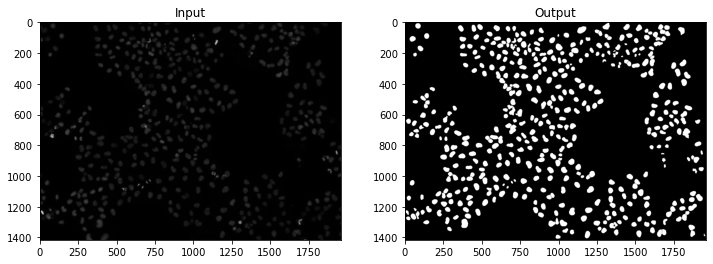

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)

# show images and set titles
ax1.imshow(image[0,...,0], cmap="gray")
#ax2.imshow(train_output[2,...,0], cmap="gray")
ax2.imshow(label[0,...,1], cmap="gray")
ax1.set_title('Input')
ax2.set_title('Output')

print(train_input.shape)
print(train_output.shape)
print(train_output.min(), train_output.max())

In [8]:
### GENERATE MODEL AND TRAIN...
model = build_model(input_data=train_input,
                    output_data=train_output,
                    start_filters=16)

callbacks = [
    ModelCheckpoint(os.path.join(model_path, "model.h5"), monitor="val_loss", verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=PATIENCE, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=PATIENCE * 3, verbose=1)
]

# steps per epoch and validation steps; depends (1) inversely on image shape and (2) number of params
#  validation steps is 1/4 of steps per epoch...
steps_per_epoch = 1e7 // (train_input.shape[1]*train_input.shape[2]*batch_size)

# train model
model.fit(training_data,
          epochs=EPOCHS,
          validation_data=validation_data,
          callbacks=callbacks
          )

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 176, 244, 256), (None, 177, 245, 128)]

In [ ]:
# load input image and model path
#input_path, model_path = load_prediction_paths()
input_path = r"c:\Users\m1srh\Documents\GitHub\ipy_notebooks\Create_czmodel\mouse_embryo\images"
model_path = r"c:\Users\m1srh\Documents\GitHub\ipy_notebooks\Create_czmodel\mouse_embryo\model.h5"

# generate path for storing predicted images
save_path = os.path.join(Path(model_path).parent, "prediction results")
if not os.path.exists(save_path):
    os.mkdir(save_path)
else:
    for file in os.listdir(save_path):
        os.remove(os.path.join(save_path, file))

# load prediction data
data, filenames = load_prediction_data(input_path)
print("prediction data shape... ", data.shape)

# load model and determine model type
model : tf.keras.Model
model = tf.keras.models.load_model(model_path)
model_type = model.name
print("model type is...", model_type)

print(data.shape)

# do prediction...
#predicted_data = np.array([model.predict_on_batch(data[i:i+1]) for i in tqdm(range(len(data)))])

predicted_data = model.predict(data, batch_size=1)

print("predicted data shape before processing...", predicted_data.shape)
print("Min-Max predicted data : ", predicted_data[...,0].min(), predicted_data[...,0].max())
print("Min-Max predicted data : ", predicted_data[...,1].min(), predicted_data[...,1].max())

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)

# show images and set titles
ax1.imshow(predicted_data[0,...,0], cmap="gray")
ax1.set_title('Input')
ax2.set_title('Output')

In [ ]:
if model_type == "segmentation":
    predicted_data = np.argmax(predicted_data, axis=-1)
    #predicted_data = (predicted_data * (65535. / predicted_data.max())).astype(np.uint16)
    #predicted_data = (predicted_data * (255. / predicted_data.max())).astype(np.uint8)
    print('Min-Max of predicted data (after argmax) : ', predicted_data.min(), predicted_data.max())

print("predicted data shape before storage : ", predicted_data.shape)

for i, filename in enumerate(filenames):
    tifffile.imwrite(os.path.join(save_path, filename), data=predicted_data[i])

print("predicition finished...")

In [ ]:
img = data[0]
print(img.shape)
pred = predicted_data[0]
print(pred.shape)
print('Min-Max of pred', pred.min(), pred.max())

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)

# show images and set titles
ax1.imshow(img[...,0], cmap="gray")
ax2.imshow(pred[0,...], cmap="gray", vmin=0, vmax=1)
ax1.set_title('Image')
ax2.set_title('Prediction')


In [ ]:
# those functions are provided by the PyPi package called czmodel (by ZEISS)
from czmodel.util.preprocessing import add_preprocessing_layers
from czmodel.model_metadata import ModelMetadata, ModelSpec
from czmodel import convert_from_model_spec, convert_from_json_spec

# Define the model metadata
model_metadata = ModelMetadata.from_params(name='Simple_Nuclei_SegmentationModel', 
                                           color_handling='ConvertToMonochrome',
                                           pixel_type='Gray16',
                                           classes=["Background", "Nucleus"],
                                           border_size=20)


# Create a model specification object used for conversion
model_spec = ModelSpec(model=model, model_metadata=model_metadata)

In [ ]:
# Define dimensions - ZEN Intellesis requires fully defined spatial dimensions.
# This is the tile size used by the ZEN TilingStrategy to pass an image to the SegmentationService.

# Define target spatial dimensions of the model for inference.
spatial_dims = 1024, 1024


# package and save as CZMODEL - for inference the model will be exported as ONNX
convert_from_model_spec(model_spec=model_spec, 
                        output_path='./czmodel_output', 
                        output_name='simple_nuclei_segmodel', 
                        spatial_dims=spatial_dims)

# In the example above there will be a ""./czmodel_output/simple_nuclei_segmodel.czmodel" file saved on disk.

In [ ]:
# save the trained TF2.SavedModel as a folder structure
# The folder + the JSON file can be also used to import the model in ZEN

model.save('./saved_tf2_model_output_dims_unset/') # save as TF.SavedModel without dims set

# add extra layer infont to define dimensions and save as TF2.SavedModel
add_preprocessing_layers(model, layers=None, spatial_dims=spatial_dims).save('./saved_tf2_model_output/')